# Multi-modal Knowledge-distilled Real-time Object Detection and Tracking

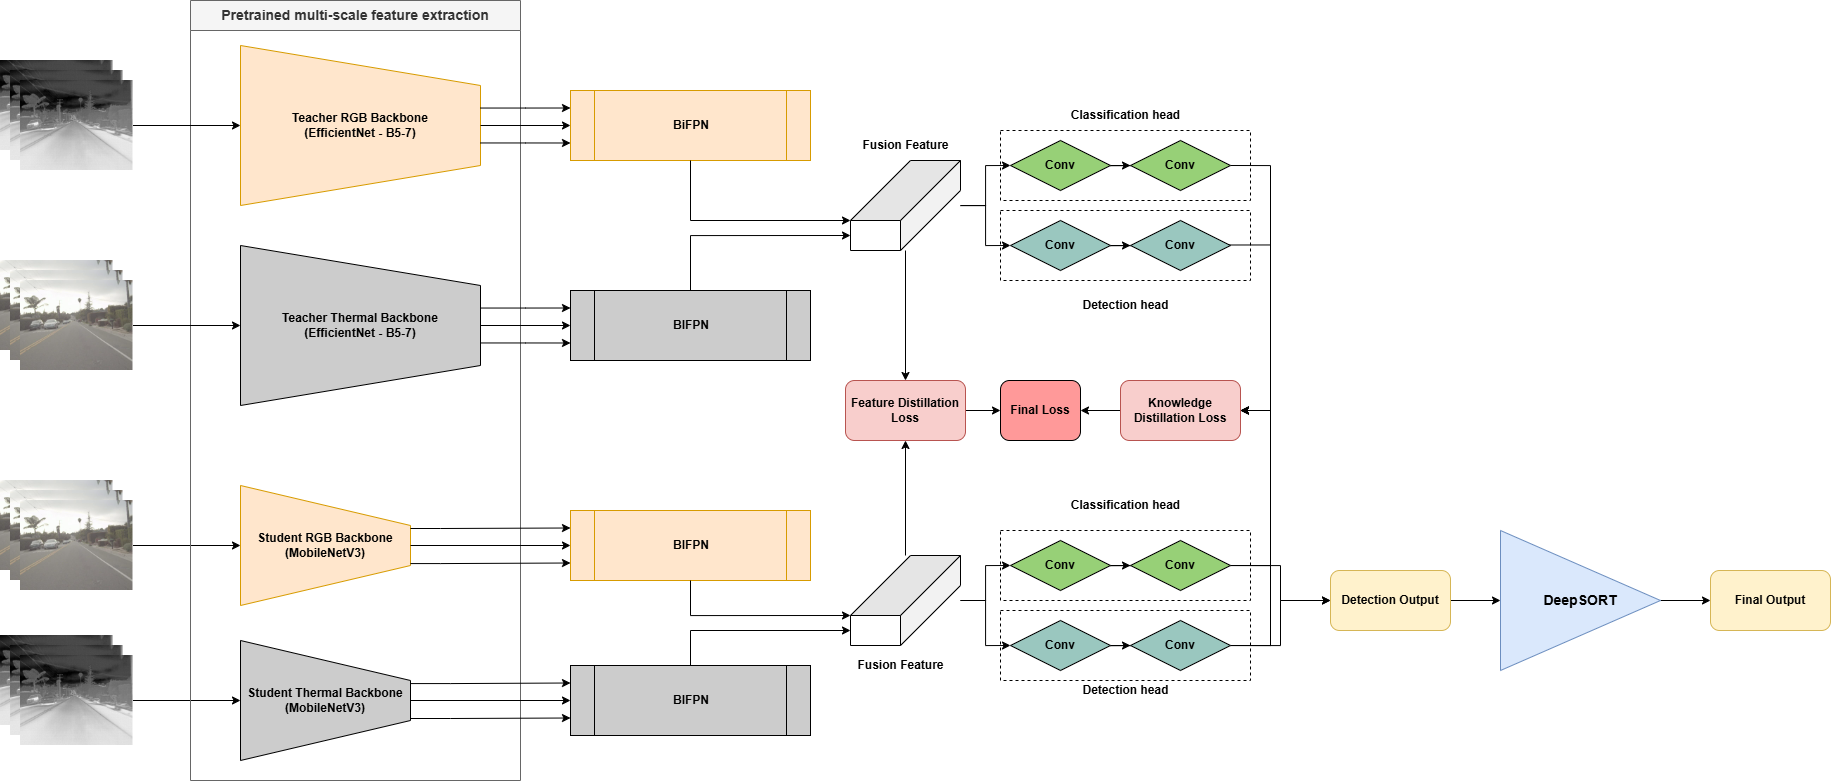

# Implementation Pipeline


Breaking down the pipeline and clarifying each step, including the training process, the roles of the teacher and student models, the use of BIFPN, the losses, and the final output with DeepSORT.



### **1. Training Data for Teacher and Student Models**

#### **Dataset for Training**
- **Dataset Composition**: The pipeline uses a dataset containing paired RGB and thermal images, likely for object detection tasks (e.g., autonomous driving or surveillance). Each sample in the dataset includes:
  - An RGB image $ I_{RGB} \in \mathbb{R}^{H \times W \times 3} $.
  - A thermal image $ I_{Thermal} \in \mathbb{R}^{H \times W \times 1} $.
  - Ground truth annotations: bounding boxes $ \{b_i\} $ and class labels $ \{y_i\} $ for objects in the images.
- **Dataset for Teacher and Student**:
  - **Same Dataset**: Both the teacher and student models are trained on the same dataset of paired RGB and thermal images. The teacher models (EfficientNet-B7) are typically pre-trained on a large dataset like ImageNet and then fine-tuned on this specific dataset for object detection.
  - **Difference in Training**:
    - **Teacher Models**: The teacher models are pre-trained and fine-tuned to achieve high accuracy. They are not trained simultaneously with the student models in this pipeline. Instead, they are already trained and frozen, serving as a source of knowledge.
    - **Student Models**: The student models (MobileNetV3) are trained from scratch or with pre-trained weights, but they are actively trained in this pipeline using knowledge distillation from the teacher models.
  - **Amount of Samples**:
    - There’s no inherent difference in the number of samples between the teacher and student datasets. Both use the same dataset for fine-tuning or training. However:
      - The teacher models might have been pre-trained on a much larger dataset (e.g., ImageNet with millions of samples) before fine-tuning on this specific dataset (e.g., a smaller dataset like FLIR ADAS with thousands of samples).
      - The student models are trained directly on the specific dataset, which might have fewer samples (e.g., 10,000 paired RGB-thermal images), depending on the application.

#### **Summary**:
- The teacher models are pre-trained and fine-tuned on the same dataset as the student models, but the teacher models are frozen during the student training phase.
- The dataset size is the same for both, but the teacher might have seen more data during its pre-training phase (e.g., ImageNet).


### **2. What We Take from Trained Teacher and Student Models Using BIFPN**

#### **Teacher and Student Models with BIFPN**
- **What We Take**:
  - From the **teacher models** (EfficientNet-B7), we extract multi-scale features for both RGB and thermal inputs. These features are used as a reference for knowledge distillation.
  - From the **student models** (MobileNetV3), we also extract multi-scale features, which are refined during training to match the teacher’s features and used for final detection.
- **Role of BIFPN**:
  - BIFPN (Bi-Directional Feature Pyramid Network) is used to enhance the multi-scale features extracted by both the teacher and student backbones. It combines features from different scales (resolutions) to improve the detection of objects of varying sizes.

#### **Input and Output of Teacher BIFPN**
- **Input**:
  - The teacher backbone (EfficientNet-B7) extracts multi-scale features from the input images:
    $$
    F_{RGB}^{teacher} = f_{teacher}^{RGB}(I_{RGB}), \quad F_{Thermal}^{teacher} = f_{teacher}^{Thermal}(I_{Thermal})
    $$
    where $ F_{RGB}^{teacher} $ and $ F_{Thermal}^{teacher} $ are sets of feature maps at different scales: $ \{F_{RGB}^{teacher, l}\}_{l=1}^L $ and $ \{F_{Thermal}^{teacher, l}\}_{l=1}^L $, with $ L $ being the number of scales (e.g., 5 levels in a typical feature pyramid).
  - These feature maps are the input to the teacher’s BIFPN.
- **Output**:
  - The teacher BIFPN refines these features by combining them across scales:
    $$
    \tilde{F}_{RGB}^{teacher} = \text{BIFPN}(F_{RGB}^{teacher}), \quad \tilde{F}_{Thermal}^{teacher} = \text{BIFPN}(F_{Thermal}^{teacher})
    $$
    where $ \tilde{F}_{RGB}^{teacher} $ and $ \tilde{F}_{Thermal}^{teacher} $ are the refined multi-scale features, still a set of feature maps $ \{\tilde{F}_{RGB}^{teacher, l}\}_{l=1}^L $ and $ \{\tilde{F}_{Thermal}^{teacher, l}\}_{l=1}^L $, but with improved cross-scale interactions.

#### **Input and Output of Student BIFPN**
- **Input**:
  - The student backbone (MobileNetV3) extracts multi-scale features:
    $$
    F_{RGB}^{student} = f_{student}^{RGB}(I_{RGB}), \quad F_{Thermal}^{student} = f_{student}^{Thermal}(I_{Thermal})
    $$
    where $ F_{RGB}^{student} $ and $ F_{Thermal}^{student} $ are sets of feature maps: $ \{F_{RGB}^{student, l}\}_{l=1}^L $ and $ \{F_{Thermal}^{student, l}\}_{l=1}^L $.
  - These feature maps are the input to the student’s BIFPN.
- **Output**:
  - The student BIFPN refines these features:
    $$
    \tilde{F}_{RGB}^{student} = \text{BIFPN}(F_{RGB}^{student}), \quad \tilde{F}_{Thermal}^{student} = \text{BIFPN}(F_{Thermal}^{student})
    $$
    where $ \tilde{F}_{RGB}^{student} $ and $ \tilde{F}_{Thermal}^{student} $ are the refined multi-scale features: $ \{\tilde{F}_{RGB}^{student, l}\}_{l=1}^L $ and $ \{\tilde{F}_{Thermal}^{student, l}\}_{l=1}^L $.

#### **Summary**:
- **Teacher BIFPN**: Input is $ F_{RGB}^{teacher} $ and $ F_{Thermal}^{teacher} $, output is $ \tilde{F}_{RGB}^{teacher} $ and $ \tilde{F}_{Thermal}^{teacher} $.
- **Student BIFPN**: Input is $ F_{RGB}^{student} $ and $ F_{Thermal}^{student} $, output is $ \tilde{F}_{RGB}^{student} $ and $ \tilde{F}_{Thermal}^{student} $.
- These refined features are used for feature distillation (comparing teacher and student features) and for further processing (fusion and detection).

### **3. What Do Teacher and Student Fusion Features Do?**

#### **Teacher Fusion Feature**
- **Purpose**: The teacher fusion feature combines the refined features from the RGB and thermal branches of the teacher model:
  $$
  F_{fused}^{teacher} = \text{Fusion}(\tilde{F}_{RGB}^{teacher}, \tilde{F}_{Thermal}^{teacher})
  $$
  where the fusion operation could be concatenation followed by a convolution:
  $$
  F_{fused}^{teacher} = \text{Conv}(\text{Concat}(\tilde{F}_{RGB}^{teacher}, \tilde{F}_{Thermal}^{teacher}))
  $$
  or a weighted sum:
  $$
  F_{fused}^{teacher} = w_{RGB} \cdot \tilde{F}_{RGB}^{teacher} + w_{Thermal} \cdot \tilde{F}_{Thermal}^{teacher}
  $$
- **Role**: The teacher fusion feature is used to generate high-quality predictions (logits for classification and bounding box offsets for detection) that serve as a target for knowledge distillation. It leverages the complementary information from RGB and thermal modalities to improve the teacher’s detection performance, which the student then learns from.

#### **Student Fusion Feature**
- **Purpose**: The student fusion feature combines the refined features from the RGB and thermal branches of the student model:
  $$
  F_{fused}^{student} = \text{Fusion}(\tilde{F}_{RGB}^{student}, \tilde{F}_{Thermal}^{student})
  $$
  using a similar fusion operation as the teacher.
- **Role**: The student fusion feature is used for two purposes:
  1. **Feature Distillation**: It is compared with the teacher fusion feature to compute the feature distillation loss, helping the student learn better feature representations.
  2. **Detection**: It is passed to the student’s classification and detection heads to produce the final detection output during inference.

#### **Summary**:
- **Teacher Fusion Feature**: Combines teacher’s RGB and thermal features to generate high-quality predictions for knowledge distillation.
- **Student Fusion Feature**: Combines student’s RGB and thermal features for feature distillation (during training) and final detection (during inference).

### **4. Teacher and Student Classification Heads**

#### **Teacher Classification Head**
- **What It Is**: The teacher classification head is a set of convolutional layers applied to the teacher’s fused features $ F_{fused}^{teacher} $:
  $$
  z_{cls}^{teacher} = \text{Conv}(F_{fused}^{teacher})
  $$
  where $ z_{cls}^{teacher} \in \mathbb{R}^{N \times C} $, with $ N $ as the number of anchors (potential object locations) and $ C $ as the number of classes.
- **Output**: The teacher classification head produces logits, which are converted to soft probabilities using a softmax with temperature $ T $ (for knowledge distillation):
  $$
  p_{teacher}(i) = \frac{\exp(z_{cls}^{teacher}(i)/T)}{\sum_j \exp(z_{cls}^{teacher}(j)/T)}
  $$
- **Role**: These soft probabilities are used as targets for the student in knowledge distillation.

#### **Student Classification Head**
- **What It Is**: The student classification head is a similar set of convolutional layers applied to the student’s fused features $ F_{fused}^{student} $:
  $$
  z_{cls}^{student} = \text{Conv}(F_{fused}^{student})
  $$
  where $ z_{cls}^{student} \in \mathbb{R}^{N \times C} $.
- **Output**: The student classification head produces logits, which are converted to soft probabilities:
  $$
  p_{student}(i) = \frac{\exp(z_{cls}^{student}(i)/T)}{\sum_j \exp(z_{cls}^{student}(j)/T)}
  $$
  During inference, these logits are converted to hard probabilities (without temperature) for final class predictions:
  $$
  \hat{y}_i = \frac{\exp(z_{cls}^{student}(i))}{\sum_j \exp(z_{cls}^{student}(j))}
  $$
- **Role**: The student classification head is used for:
  1. Computing the knowledge distillation loss (by comparing $ p_{student} $ with $ p_{teacher} $).
  2. Producing the final class predictions during inference.

#### **Summary**:
- **Teacher Classification Head**: Produces soft probabilities for knowledge distillation.
- **Student Classification Head**: Produces soft probabilities for training (knowledge distillation) and hard probabilities for inference (final detection).

### **5. Forming the Losses**

#### **Knowledge Distillation Loss**
- **Yes**, the teacher and student classification heads are used to form the knowledge distillation loss. The loss is computed as the Kullback-Leibler (KL) divergence between the teacher’s and student’s soft probabilities:
  $$
  L_{KD} = T^2 \cdot \text{KL}(p_{teacher} \| p_{student}) = T^2 \cdot \sum_i p_{teacher}(i) \log \frac{p_{teacher}(i)}{p_{student}(i)}
  $$
  where $ T $ is the temperature parameter that softens the probabilities.

#### **Feature Distillation Loss**
- **Yes**, the teacher and student fusion features are used to form the feature distillation loss. The loss is typically the mean squared error (MSE) between the teacher’s and student’s fused features:
  $$
  L_{feat} = \frac{1}{N} \|F_{fused}^{teacher} - F_{fused}^{student}\|_2^2
  $$
  where $ N $ is a normalization factor (e.g., the number of elements in the feature maps).

#### **Final Loss**
- **Yes**, the final loss combines the knowledge distillation loss, feature distillation loss, and the standard detection loss:
  $$
  L_{final} = \alpha L_{det} + \beta L_{feat} + \gamma L_{KD}
  $$
  where:
  - $ L_{det} = L_{cls} + L_{reg} $:
    - $ L_{cls} $: Cross-entropy loss between the student’s class predictions and ground truth labels.
    - $ L_{reg} $: Smooth L1 loss between the student’s predicted bounding boxes and ground truth boxes.
  - $ \alpha, \beta, \gamma $: Hyperparameters to balance the losses.

#### **Summary**:
- Knowledge distillation loss: From teacher and student classification heads.
- Feature distillation loss: From teacher and student fusion features.
- Final loss: Combines detection loss, feature distillation loss, and knowledge distillation loss.

### **6. What Do We Do with the Final Loss? Training What?**

#### **Using the Final Loss**
- **Training the Student Model**:
  - The final loss $ L_{final} $ is used to train the **student model** (MobileNetV3 backbone, BIFPN, fusion layer, classification head, and detection head).
  - The teacher model is frozen (not updated) during this process. The teacher’s role is to provide supervision (via features and predictions) for the student.
- **Optimization**:
  - The student model’s parameters $ \theta_{student} $ are updated using backpropagation and an optimizer (e.g., Adam):
    $$
    \theta_{student} \leftarrow \theta_{student} - \eta \nabla_{\theta_{student}} L_{final}
    $$
    where $ \eta $ is the learning rate.
- **Goal**:
  - The final loss ensures that the student model:
    1. Learns to detect objects accurately (via $ L_{det} $).
    2. Mimics the teacher’s feature representations (via $ L_{feat} $).
    3. Mimics the teacher’s predictions (via $ L_{KD} $).
  - This results in a lightweight student model (MobileNetV3) that achieves performance close to the heavier teacher model (EfficientNet-B7) while being more efficient.

#### **Summary**:
- The final loss is used to train the student model, optimizing its parameters to improve detection performance while learning from the teacher.

### **7. Detection Output of the Student Model and Improvement by Final Loss**

#### **Detection Output of the Student Model**
- **What It Is**:
  - The detection output of the student model consists of:
    - Bounding boxes $ \hat{b}_i $: Predicted by the student’s detection head.
    - Class probabilities $ \hat{y}_i $: Predicted by the student’s classification head.
  - These are generated by passing the student’s fused features $ F_{fused}^{student} $ through the detection and classification heads:
    $$
    z_{cls}^{student} = \text{Conv}(F_{fused}^{student}), \quad z_{reg}^{student} = \text{Conv}(F_{fused}^{student})
    $$
    $$
    \hat{y}_i = \text{Softmax}(z_{cls}^{student}), \quad \hat{b}_i = a_i + z_{reg}^{student}
    $$
    where $ a_i $ are anchor boxes.
  - Non-maximum suppression (NMS) is applied to remove overlapping detections, resulting in the final set of detections: $ \{(\hat{b}_i, \hat{y}_i)\} $.

#### **Improved by the Final Loss?**
- **Yes**, the detection output of the student model is improved by the final loss:
  - **Detection Loss ($ L_{det} $)**: Directly optimizes the student’s detection and classification heads to match ground truth annotations, improving the accuracy of $ \hat{b}_i $ and $ \hat{y}_i $.
  - **Feature Distillation Loss ($ L_{feat} $)**: Ensures that the student’s fused features $ F_{fused}^{student} $ are similar to the teacher’s $ F_{fused}^{teacher} $, which are more informative and robust. This improves the quality of the features used for detection.
  - **Knowledge Distillation Loss ($ L_{KD} $)**: Encourages the student’s classification head to produce predictions similar to the teacher’s, which are more accurate. This improves the class probabilities $ \hat{y}_i $.
- **Overall Impact**:
  - The final loss makes the student model more accurate and robust by leveraging the teacher’s knowledge, resulting in better detection performance (higher precision and recall) compared to training the student model alone without distillation.

#### **Summary**:
- The student’s detection output is the set of bounding boxes and class probabilities.
- The final loss improves this output by optimizing the student model to match both the ground truth and the teacher’s knowledge.

### **8. Input and Output of DeepSORT**

#### **Input to DeepSORT**
- **Input**:
  - The detection output from the student model: $ \{(\hat{b}_i, \hat{y}_i)\} $, where:
    - $ \hat{b}_i = [x, y, w, h] $: Bounding box coordinates (center $ x, y $, width $ w $, height $ h $).
    - $ \hat{y}_i $: Class probabilities or labels.
  - Additionally, DeepSORT requires appearance features for each detection, typically extracted using a small CNN (e.g., a pre-trained ResNet):
    $$
    f_i = \text{CNN}(\text{Crop}(I, \hat{b}_i))
    $$
    where $ f_i $ is the appearance feature vector for detection $ i $, and $ \text{Crop}(I, \hat{b}_i) $ extracts the image patch within the bounding box $ \hat{b}_i $.

#### **Output of DeepSORT**
- **Output**:
  - A set of tracked objects with assigned track IDs: $ \{(\hat{b}_i, \hat{y}_i, \text{ID}_i)\} $, where:
    - $ \hat{b}_i $: Updated bounding box (possibly refined by the Kalman filter).
    - $ \hat{y}_i $: Class label (unchanged from the detection).
    - $ \text{ID}_i $: A unique track ID assigned to each object, consistent across frames.
- **Process**:
  - DeepSORT uses a Kalman filter to predict the position of existing tracks and a Hungarian algorithm to associate detections with tracks based on motion and appearance costs (as described in the previous mathematical description).

#### **Summary**:
- **Input**: Detections $ \{(\hat{b}_i, \hat{y}_i)\} $ and their appearance features $ \{f_i\} $.
- **Output**: Tracked objects $ \{(\hat{b}_i, \hat{y}_i, \text{ID}_i)\} $.

### **9. Final Output**

#### **What Is the Final Output?**
- The final output of the pipeline is the result of DeepSORT:
  $$
  \{(\hat{b}_i, \hat{y}_i, \text{ID}_i)\}
  $$
  where:
  - $ \hat{b}_i $: Bounding box of the detected object.
  - $ \hat{y}_i $: Class label of the detected object (e.g., “car,” “pedestrian”).
  - $ \text{ID}_i $: Track ID for consistent tracking across frames.
- This output represents the tracked objects in the scene, combining detection (from the student model) and tracking (from DeepSORT).

#### **Summary**:
- The final output is a set of tracked objects with bounding boxes, class labels, and track IDs, suitable for applications like autonomous driving or surveillance.

### **Pipeline Summary**
1. **Training Data**:
   - Same dataset of paired RGB and thermal images for both teacher and student.
   - Teacher is pre-trained and fine-tuned, student is trained with distillation.
2. **Teacher and Student Models with BIFPN**:
   - Teacher BIFPN: Input is raw features $ F_{RGB}^{teacher}, F_{Thermal}^{teacher} $, output is refined features $ \tilde{F}_{RGB}^{teacher}, \tilde{F}_{Thermal}^{teacher} $.
   - Student BIFPN: Input is raw features $ F_{RGB}^{student}, F_{Thermal}^{student} $, output is refined features $ \tilde{F}_{RGB}^{student}, \tilde{F}_{Thermal}^{student} $.
3. **Fusion Features**:
   - Teacher fusion feature: Combines teacher’s RGB and thermal features for knowledge distillation.
   - Student fusion feature: Combines student’s RGB and thermal features for distillation and detection.
4. **Classification Heads**:
   - Teacher classification head: Produces soft probabilities for knowledge distillation.
   - Student classification head: Produces probabilities for distillation (training) and detection (inference).
5. **Losses**:
   - Knowledge distillation loss: From teacher and student classification heads.
   - Feature distillation loss: From teacher and student fusion features.
   - Final loss: Combines detection loss, feature distillation loss, and knowledge distillation loss.
6. **Training with Final Loss**:
   - The final loss trains the student model, improving its detection performance.
7. **Detection Output**:
   - Student model produces bounding boxes and class probabilities, improved by the final loss.
8. **DeepSORT**:
   - Input: Detections and appearance features.
   - Output: Tracked objects with track IDs.
9. **Final Output**:
   - Tracked objects with bounding boxes, class labels, and track IDs.


# Theoretical Framework

The pipeline provided is a sophisticated deep learning architecture for multi-modal object detection and tracking, specifically designed to leverage both RGB and thermal images. The general theoretical framework behind this pipeline integrates several key concepts from computer vision, deep learning, and machine learning. Below, we outline the theoretical foundations, tying them to the specific components of the pipeline (teacher-student framework, knowledge distillation, multi-modal fusion, feature pyramids, and tracking with DeepSORT).


### **1. Multi-Modal Learning**
#### **Theoretical Foundation**
- **Concept**: Multi-modal learning involves combining information from multiple data sources (modalities) to improve model performance. In this pipeline, the modalities are RGB images (color) and thermal images (infrared).
- **Rationale**: Different modalities provide complementary information:
  - RGB images capture detailed color and texture information, which is effective in good lighting conditions.
  - Thermal images capture heat signatures, which are robust in low-light, adverse weather, or occluded scenarios (e.g., night, fog).
- **Theoretical Goal**: By fusing these modalities, the model can achieve better robustness and generalization compared to using a single modality. This is grounded in the idea of **information fusion**, where the combined representation is more informative than the individual modalities.

#### **Application in the Pipeline**
- The pipeline processes RGB and thermal images separately through their respective backbones (EfficientNet-B7 for the teacher, MobileNetV3 for the student).
- Features from both modalities are fused (via the "Fusion Feature" step) to create a unified representation that leverages the strengths of both RGB and thermal data.
- **Theoretical Insight**: The fusion step can be viewed as a form of **late fusion**, where features are extracted independently and then combined, as opposed to early fusion (combining raw inputs) or intermediate fusion (combining features at multiple stages).



### **2. Teacher-Student Framework and Knowledge Distillation**
#### **Theoretical Foundation**
- **Concept**: The teacher-student framework is a form of **model compression** and **knowledge transfer**. It originates from the idea of **knowledge distillation** (Hinton et al., 2015), where a larger, more accurate model (teacher) transfers its knowledge to a smaller, more efficient model (student).
- **Rationale**:
  - Large models (e.g., EfficientNet-B7) are highly accurate but computationally expensive, making them impractical for real-time applications like autonomous driving.
  - Smaller models (e.g., MobileNetV3) are efficient but less accurate.
  - Knowledge distillation bridges this gap by training the student to mimic the teacher’s behavior, achieving a balance between accuracy and efficiency.
- **Theoretical Goal**: The student learns not only from the ground truth (hard labels) but also from the teacher’s predictions (soft labels) and intermediate representations. This is based on the idea that the teacher’s outputs contain richer information (e.g., class correlations, uncertainty) than hard labels alone.

#### **Application in the Pipeline**
- **Teacher Models**: Two EfficientNet-B7 models (one for RGB, one for thermal) serve as the teachers. They are pre-trained and fine-tuned to achieve high accuracy.
- **Student Models**: Two MobileNetV3 models (one for RGB, one for thermal) are the students, trained to be lightweight and efficient.
- **Knowledge Distillation**:
  - **Feature Distillation Loss**: The student learns to match the teacher’s intermediate features (after BIFPN and fusion). This is based on the idea that the teacher’s features are more informative and robust.
  - **Knowledge Distillation Loss**: The student learns from the teacher’s soft probabilities (logits from the classification head), capturing the teacher’s understanding of class relationships.
- **Theoretical Insight**: This framework leverages **representation learning** (feature distillation) and **soft target learning** (knowledge distillation) to transfer the teacher’s generalization ability to the student, improving the student’s performance beyond what it could achieve with ground truth alone.



### **3. Feature Pyramid Networks (FPN) and Bi-Directional FPN (BIFPN)**
#### **Theoretical Foundation**
- **Concept**: Feature Pyramid Networks (FPN) (Lin et al., 2017) address the challenge of detecting objects at different scales in an image. FPN creates a multi-scale feature hierarchy by combining low-level (high-resolution) and high-level (low-resolution) features.
- **Rationale**:
  - Low-level features capture fine-grained details (e.g., edges, textures) but lack semantic context.
  - High-level features capture semantic context (e.g., object categories) but have low resolution, making them less effective for small objects.
  - FPN combines these features through a top-down pathway (propagating high-level semantics to lower levels) and lateral connections (integrating low-level details).
- **Bi-Directional FPN (BIFPN)**: An advanced version of FPN introduced in EfficientDet (Tan et al., 2020). BIFPN adds a bottom-up pathway and weighted feature fusion to improve cross-scale interactions.
- **Theoretical Goal**: BIFPN aims to create a more balanced and effective multi-scale feature representation, improving detection performance for objects of varying sizes.

#### **Application in the Pipeline**
- Both the teacher and student models use BIFPN after their backbones (EfficientNet-B7 and MobileNetV3) to refine multi-scale features.
- **Input to BIFPN**: Raw multi-scale features extracted by the backbone (e.g., $ \{F^{l}\}_{l=1}^L $, where $ l $ is the scale level).
- **Output of BIFPN**: Refined multi-scale features (e.g., $ \{\tilde{F}^{l}\}_{l=1}^L $) with improved cross-scale interactions.
- **Theoretical Insight**: BIFPN enhances the model’s ability to detect objects of different sizes (e.g., a distant pedestrian vs. a nearby car), which is critical for applications like autonomous driving.



### **4. Multi-Modal Feature Fusion**
#### **Theoretical Foundation**
- **Concept**: Feature fusion in multi-modal learning involves combining representations from different modalities to create a unified representation. This is grounded in **information theory**, where the goal is to maximize the mutual information between the fused representation and the task (e.g., object detection).
- **Rationale**:
  - RGB and thermal features capture different aspects of the scene (color/texture vs. heat signatures).
  - Fusing these features allows the model to exploit complementary information, improving robustness and accuracy.
- **Theoretical Goal**: The fused representation should be more discriminative than the individual modality representations, enabling better detection performance.

#### **Application in the Pipeline**
- The pipeline performs feature fusion after BIFPN, combining the refined RGB and thermal features:
  - For the teacher: $ F_{fused}^{teacher} = \text{Fusion}(\tilde{F}_{RGB}^{teacher}, \tilde{F}_{Thermal}^{teacher}) $.
  - For the student: $ F_{fused}^{student} = \text{Fusion}(\tilde{F}_{RGB}^{student}, \tilde{F}_{Thermal}^{student}) $.
- The fusion operation could be concatenation followed by a convolution or a weighted sum, depending on the implementation.
- **Theoretical Insight**: This step aligns with the principle of **late fusion**, where features are extracted independently and then combined, allowing each modality to be processed optimally before fusion.



### **5. Object Detection Framework**
#### **Theoretical Foundation**
- **Concept**: The pipeline is built on a modern object detection framework, likely inspired by architectures like Faster R-CNN, YOLO, or EfficientDet.
- **Rationale**:
  - Object detection involves two tasks: **classification** (identifying the object class) and **regression** (predicting the bounding box).
  - Modern detectors use a **region proposal** or **anchor-based** approach, where the model predicts class probabilities and bounding box offsets for a set of predefined anchors.
- **Theoretical Goal**: The model learns a mapping from input images to a set of detections $ \{(\hat{b}_i, \hat{y}_i)\} $, where $ \hat{b}_i $ is the bounding box and $ \hat{y}_i $ is the class probability, by minimizing a combined loss (classification + regression).

#### **Application in the Pipeline**
- The pipeline includes **classification heads** and **detection heads**:
  - **Classification Head**: Predicts class probabilities for each anchor using the fused features.
  - **Detection Head**: Predicts bounding box offsets for each anchor.
- The student model produces the final detection output, which is improved through knowledge distillation.
- **Theoretical Insight**: This aligns with the **two-stage** or **one-stage** detection paradigm, where the model first extracts features and then predicts detections, with the added benefit of multi-modal fusion and distillation.



### **6. DeepSORT for Object Tracking**
#### **Theoretical Foundation**
- **Concept**: DeepSORT (Wojke et al., 2017) is an extension of the SORT (Simple Online and Realtime Tracking) algorithm, combining **motion-based tracking** and **appearance-based tracking**.
- **Rationale**:
  - Motion-based tracking (using a Kalman filter) predicts the position of objects across frames based on their dynamics.
  - Appearance-based tracking (using deep features) ensures robust association of detections to tracks, even when motion predictions are uncertain (e.g., occlusions, crowded scenes).
- **Theoretical Goal**: DeepSORT solves the **data association problem** in multi-object tracking by minimizing a cost function that combines motion and appearance distances, using the Hungarian algorithm for optimal assignment.

#### **Application in the Pipeline**
- **Input to DeepSORT**: The detection output from the student model (bounding boxes and class probabilities) and appearance features extracted from the detections.
- **Output of DeepSORT**: Tracked objects with consistent track IDs across frames: $ \{(\hat{b}_i, \hat{y}_i, \text{ID}_i)\} $.
- **Theoretical Insight**: DeepSORT leverages **Bayesian filtering** (Kalman filter for motion) and **deep metric learning** (appearance features) to achieve robust tracking, making the pipeline suitable for applications requiring temporal consistency (e.g., autonomous driving).



### **7. Loss Function Design**
#### **Theoretical Foundation**
- **Concept**: The pipeline uses a multi-task loss function to optimize the student model, combining:
  - **Detection Loss**: Standard loss for object detection (classification + regression).
  - **Feature Distillation Loss**: Encourages the student to match the teacher’s intermediate features.
  - **Knowledge Distillation Loss**: Encourages the student to match the teacher’s predictions.
- **Rationale**:
  - The detection loss ensures the student learns the primary task (object detection).
  - The distillation losses transfer the teacher’s knowledge, improving the student’s generalization and robustness.
- **Theoretical Goal**: The combined loss aligns with **multi-task learning**, where the model optimizes multiple objectives simultaneously, with hyperparameters ($ \alpha, \beta, \gamma $) balancing the contributions of each loss.

#### **Application in the Pipeline**
- The final loss is:
  $$
  L_{final} = \alpha L_{det} + \beta L_{feat} + \gamma L_{KD}
  $$
  where:
  - $ L_{det} $: Detection loss (classification + regression).
  - $ L_{feat} $: Feature distillation loss (MSE between teacher and student features).
  - $ L_{KD} $: Knowledge distillation loss (KL divergence between teacher and student predictions).
- **Theoretical Insight**: This loss design leverages **transfer learning** (distillation) and **regularization** (feature matching) to improve the student’s performance.




## **General Theoretical Framework**
The pipeline can be summarized as a **multi-modal, knowledge-distilled object detection and tracking framework**, integrating the following theoretical principles:

1. **Multi-Modal Learning**:
   - Combines RGB and thermal data to improve robustness, grounded in information fusion theory.
2. **Teacher-Student Learning with Knowledge Distillation**:
   - Transfers knowledge from a large teacher model to a small student model, based on model compression and knowledge transfer.
3. **Multi-Scale Feature Extraction with BIFPN**:
   - Enhances feature representations for objects of different sizes, rooted in feature pyramid networks and representation learning.
4. **Feature Fusion**:
   - Fuses multi-modal features to create a unified representation, aligned with late fusion strategies in multi-modal learning.
5. **Object Detection**:
   - Predicts bounding boxes and class probabilities, following modern detection frameworks (e.g., anchor-based detectors).
6. **Object Tracking with DeepSORT**:
   - Tracks objects across frames using motion and appearance cues, based on Bayesian filtering and deep metric learning.
7. **Multi-Task Loss Optimization**:
   - Combines detection and distillation losses to train the student model, leveraging multi-task learning and transfer learning.



### **Theoretical Motivation**
The pipeline is motivated by the need for **efficient, robust, and accurate object detection and tracking** in challenging scenarios (e.g., autonomous driving in varied lighting conditions). The theoretical framework addresses several challenges:
- **Efficiency**: Using a lightweight student model (MobileNetV3) for real-time performance, with knowledge distillation to maintain accuracy.
- **Robustness**: Combining RGB and thermal data to handle diverse conditions (day, night, fog).
- **Scalability**: Using BIFPN to detect objects of different sizes.
- **Temporal Consistency**: Using DeepSORT for tracking objects across frames.



### **Connections to Broader Research**
- **Multi-Modal Learning**: Builds on research in multi-modal fusion (e.g., RGB-D, RGB-thermal fusion for autonomous driving).
- **Knowledge Distillation**: Extends Hinton’s original work on distillation, applying it to object detection and multi-modal settings.
- **Feature Pyramids**: Leverages advancements in FPN and BIFPN for multi-scale feature extraction.
- **Object Tracking**: Incorporates DeepSORT, a widely used tracking algorithm in computer vision.


# Research Direction

The pipeline we provided is grounded in a theoretical framework with seven key aspects: multi-modal learning, teacher-student learning with knowledge distillation, multi-scale feature extraction with BIFPN, feature fusion, object detection, object tracking with DeepSORT, and multi-task loss optimization. For academic research—particularly research that emphasizes long-term exploration, deeper mathematical foundations, more theoretical advancements, and less focus on immediate engineering or implementation—these aspects can be prioritized based on their potential for theoretical innovation and mathematical depth.

Below, we evaluate each aspect to identify which ones are most suitable for such academic research, focusing on their theoretical complexity, potential for long-term exploration, and reliance on mathematics over engineering.



### **Evaluation of the 7 Aspects for Academic Research**

#### **1. Multi-Modal Learning**
- **Theoretical Depth**: High
  - Multi-modal learning involves understanding how to effectively combine information from different modalities (e.g., RGB and thermal). This requires theoretical advancements in **information theory** (e.g., maximizing mutual information between modalities and the task), **representation learning** (e.g., learning joint embeddings), and **statistical modeling** (e.g., modeling cross-modal dependencies).
- **Mathematical Complexity**: High
  - Research in this area often involves mathematical formulations such as mutual information:
    $$
    I(X_{RGB}, X_{Thermal}; Y) = H(Y) - H(Y | X_{RGB}, X_{Thermal})
    $$
    where $ X_{RGB} $ and $ X_{Thermal} $ are the modalities, $ Y $ is the task output (e.g., detection labels), and $ H $ is entropy.
  - Other mathematical tools include probabilistic graphical models, canonical correlation analysis (CCA), and variational inference for learning joint distributions.
- **Long-Term Research Potential**: High
  - Open questions include: How to optimally combine modalities? How to handle missing modalities? How to model cross-modal interactions at a theoretical level? These questions require long-term exploration and are less tied to immediate engineering solutions.
- **Engineering vs. Theory**: More Theoretical
  - While engineering is needed to implement fusion (e.g., designing fusion layers), the core research questions are theoretical, focusing on understanding the fundamental principles of multi-modal integration.
- **Suitability for Academic Research**: **High**
  - This aspect is ideal for academic research due to its theoretical depth, mathematical complexity, and open-ended questions. It can lead to new frameworks for multi-modal learning that generalize beyond RGB-thermal to other modalities (e.g., audio, text, LiDAR).

#### **2. Teacher-Student Learning with Knowledge Distillation**
- **Theoretical Depth**: High
  - Knowledge distillation (KD) is rooted in **transfer learning** and **model compression**. The theoretical questions include: What knowledge is being transferred? How does the student’s capacity affect the transfer? How can we quantify the generalization gap between teacher and student?
- **Mathematical Complexity**: High
  - KD involves mathematical formulations like the Kullback-Leibler (KL) divergence for the knowledge distillation loss:
    $$
    L_{KD} = T^2 \cdot \sum_i p_{teacher}(i) \log \frac{p_{teacher}(i)}{p_{student}(i)}
    $$
    where $ p_{teacher} $ and $ p_{student} $ are softened probabilities, and $ T $ is the temperature.
  - Feature distillation involves optimizing a distance metric (e.g., MSE) between teacher and student features, which can be analyzed through the lens of **representation learning** and **functional approximation**.
  - Theoretical research can explore the **information bottleneck principle** to understand what information the teacher transfers to the student.
- **Long-Term Research Potential**: High
  - Open questions include: How to distill knowledge across heterogeneous architectures? How to distill knowledge in multi-modal settings? How to theoretically guarantee the student’s performance? These questions require long-term theoretical exploration.
- **Engineering vs. Theory**: Balanced, but Leans Theoretical
  - While KD has practical applications (e.g., model deployment), the core research questions are theoretical, focusing on understanding the transfer process and developing new distillation methods.
- **Suitability for Academic Research**: **High**
  - KD is a strong candidate for academic research due to its theoretical depth and mathematical complexity. It offers opportunities to develop new theories of knowledge transfer, especially in multi-modal and multi-task settings.

#### **3. Multi-Scale Feature Extraction with BIFPN**
- **Theoretical Depth**: Moderate
  - BIFPN (Bi-Directional Feature Pyramid Network) builds on the concept of feature pyramids, which address the challenge of detecting objects at different scales. The theoretical foundation lies in **multi-scale representation learning** and **hierarchical feature integration**.
- **Mathematical Complexity**: Moderate
  - BIFPN involves weighted feature fusion across scales:
    $$
    F^{l, out} = \sum_{i} w_i \cdot \text{Conv}(\text{Resize}(F^{i, in}))
    $$
    where $ w_i $ are learnable weights. The mathematics is relatively straightforward (convolutions, resizing, weighted sums), but theoretical questions arise in optimizing the weights and understanding the impact of cross-scale interactions.
  - Research could involve analyzing the **receptive field** of features at different scales or using **spectral analysis** to study the frequency components of multi-scale features.
- **Long-Term Research Potential**: Moderate
  - While BIFPN is an advancement over FPN, the core idea of feature pyramids is well-established. Long-term research could focus on theoretical questions like: How to optimally design multi-scale architectures? How to balance computational cost and performance across scales? However, these questions are more incremental than foundational.
- **Engineering vs. Theory**: More Engineering
  - BIFPN research often focuses on practical improvements (e.g., efficiency, performance on benchmarks), which leans toward engineering. Theoretical advancements are possible but less central.
- **Suitability for Academic Research**: **Moderate**
  - BIFPN is less suited for purely theoretical research compared to multi-modal learning or KD. It’s more relevant for applied research aiming to improve detection architectures, though some theoretical questions (e.g., optimal scale integration) could be explored.

#### **4. Feature Fusion**
- **Theoretical Depth**: High
  - Feature fusion in multi-modal learning is closely tied to multi-modal learning (Aspect 1). The theoretical foundation involves understanding how to combine representations to maximize task performance, often using **information theory** or **representation learning**.
- **Mathematical Complexity**: High
  - Fusion can be analyzed through mutual information:
    $$
    I(F_{fused}; Y) \geq \max(I(F_{RGB}; Y), I(F_{Thermal}; Y))
    $$
    where $ F_{fused} $ is the fused feature, and the goal is to ensure the fused representation is more informative than individual modalities.
  - Advanced fusion methods might involve **tensor decomposition**, **attention mechanisms**, or **variational autoencoders** to learn joint representations, all of which require significant mathematical modeling.
- **Long-Term Research Potential**: High
  - Open questions include: What is the optimal fusion strategy (early, intermediate, late)? How to handle modality imbalance (e.g., one modality being noisier)? How to fuse features in a theoretically grounded way? These questions are long-term and theoretical in nature.
- **Engineering vs. Theory**: More Theoretical
  - While fusion requires engineering to implement (e.g., designing fusion layers), the core research questions are theoretical, focusing on understanding the principles of effective fusion.
- **Suitability for Academic Research**: **High**
  - Feature fusion is highly suitable for academic research due to its theoretical depth, mathematical complexity, and long-term research potential. It overlaps with multi-modal learning but focuses specifically on the fusion mechanism.

#### **5. Object Detection**
- **Theoretical Depth**: Moderate
  - Object detection frameworks (e.g., Faster R-CNN, YOLO, EfficientDet) are well-established, with theoretical foundations in **statistical learning** (e.g., optimizing a loss function) and **computer vision** (e.g., anchor-based detection).
- **Mathematical Complexity**: Moderate
  - The detection loss typically combines classification and regression:
    $$
    L_{det} = L_{cls} + L_{reg}
    $$
    where $ L_{cls} $ is cross-entropy and $ L_{reg} $ is Smooth L1 loss. The mathematics is standard and well-understood.
  - Theoretical research could involve analyzing the **generalization error** of detection models or developing new loss functions, but these are often incremental improvements.
- **Long-Term Research Potential**: Moderate
  - Object detection is a mature field, with most research focusing on incremental improvements (e.g., better architectures, faster inference). Long-term theoretical questions (e.g., how to unify detection and segmentation) exist but are less central to this pipeline.
- **Engineering vs. Theory**: More Engineering
  - Modern object detection research often focuses on practical improvements (e.g., speed, accuracy on benchmarks), which is more engineering-oriented.
- **Suitability for Academic Research**: **Low to Moderate**
  - Object detection is less suited for purely theoretical research in this context, as it’s a well-explored area. However, some theoretical questions (e.g., robustness to occlusion, theoretical limits of detection) could be pursued.

#### **6. Object Tracking with DeepSORT**
- **Theoretical Depth**: Moderate to High
  - DeepSORT combines **Bayesian filtering** (Kalman filter for motion) and **deep metric learning** (appearance features for association). The theoretical foundation involves:
    - **Kalman Filtering**: A probabilistic framework for state estimation.
    - **Data Association**: Solving the assignment problem using the Hungarian algorithm.
    - **Metric Learning**: Learning a distance metric for appearance-based matching.
- **Mathematical Complexity**: High
  - The Kalman filter involves state-space modeling:
    $$
    x_t = A x_{t-1} + w, \quad z_t = H x_t + v
    $$
    where $ x_t $ is the state, $ z_t $ is the measurement, and $ w, v $ are noise terms.
  - The cost function for data association combines motion and appearance:
    $$
    c(d_t, k_{t-1}) = \lambda \cdot d_{motion}(d_t, \hat{x}_{t|t-1}) + (1-\lambda) \cdot d_{appearance}(f(d_t), f(k_{t-1}))
    $$
    where $ d_{motion} $ is the Mahalanobis distance, and $ d_{appearance} $ is the cosine distance.
- **Long-Term Research Potential**: Moderate to High
  - Open questions include: How to handle long-term occlusions? How to improve appearance models with limited data? How to unify detection and tracking in a single framework? These questions have theoretical depth but are often tied to practical challenges.
- **Engineering vs. Theory**: Balanced
  - DeepSORT research involves both theory (e.g., improving the Kalman filter, designing better appearance models) and engineering (e.g., optimizing for real-time performance).
- **Suitability for Academic Research**: **Moderate to High**
  - DeepSORT is suitable for academic research, particularly in areas like improving the theoretical foundations of tracking (e.g., better probabilistic models, new association methods). However, much of the current research focuses on practical improvements, which leans toward engineering.

#### **7. Multi-Task Loss Optimization**
- **Theoretical Depth**: High
  - Multi-task loss optimization involves balancing multiple objectives (detection, feature distillation, knowledge distillation). The theoretical foundation lies in **multi-task learning**, **optimization theory**, and **regularization**.
- **Mathematical Complexity**: High
  - The final loss is a weighted combination:
    $$
    L_{final} = \alpha L_{det} + \beta L_{feat} + \gamma L_{KD}
    $$
    Theoretical research can involve:
    - **Gradient Analysis**: Understanding how gradients from different losses interact (e.g., gradient conflict in multi-task learning).
    - **Hyperparameter Optimization**: Developing theoretical methods to balance $ \alpha, \beta, \gamma $, such as using **Pareto optimization** or **game theory**.
    - **Generalization Bounds**: Analyzing how the combined loss affects the model’s generalization (e.g., using PAC-Bayesian theory).
- **Long-Term Research Potential**: High
  - Open questions include: How to theoretically balance multiple losses? How to design losses that minimize negative transfer between tasks? How to ensure robustness in multi-task settings? These are long-term, theoretical questions.
- **Engineering vs. Theory**: More Theoretical
  - While implementing the loss requires engineering, the core research questions are theoretical, focusing on understanding the optimization dynamics and designing better loss functions.
- **Suitability for Academic Research**: **High**
  - Multi-task loss optimization is highly suitable for academic research due to its theoretical depth, mathematical complexity, and long-term research potential. It offers opportunities to develop new optimization frameworks for multi-task learning.



### **Prioritization for Academic Research**

#### **Most Suitable Aspects (High Priority)**
These aspects are ideal for academic research requiring long-term exploration, more mathematics, more theory, and less engineering:

1. **Multi-Modal Learning**:
   - **Why**: Offers deep theoretical questions (e.g., optimal modality integration, handling missing modalities) and requires advanced mathematical tools (e.g., information theory, probabilistic modeling).
   - **Research Direction**: Develop new theoretical frameworks for multi-modal learning, such as variational methods for joint representation learning or information-theoretic bounds for fusion.
2. **Teacher-Student Learning with Knowledge Distillation**:
   - **Why**: Involves fundamental questions about knowledge transfer, with significant mathematical depth (e.g., KL divergence, information bottleneck).
   - **Research Direction**: Explore new distillation methods (e.g., cross-modal distillation, distillation for heterogeneous architectures) or develop theoretical guarantees for student performance.
3. **Feature Fusion**:
   - **Why**: Closely tied to multi-modal learning, with theoretical questions about optimal fusion strategies and mathematical complexity (e.g., mutual information, tensor methods).
   - **Research Direction**: Investigate new fusion mechanisms (e.g., attention-based fusion, tensor decomposition) or develop theoretical models for cross-modal feature alignment.
4. **Multi-Task Loss Optimization**:
   - **Why**: Offers theoretical challenges in balancing multiple objectives, with mathematical depth in optimization theory and generalization analysis.
   - **Research Direction**: Develop new theoretical methods for loss balancing (e.g., using game theory, Pareto optimization) or analyze the impact of multi-task learning on generalization.

#### **Moderately Suitable Aspects (Medium Priority)**
These aspects have some theoretical potential but are more balanced between theory and engineering:

5. **Multi-Scale Feature Extraction with BIFPN**:
   - **Why**: Has some theoretical questions (e.g., optimal scale integration) but is more focused on practical improvements.
   - **Research Direction**: Theoretical research could focus on analyzing the impact of cross-scale interactions on detection performance or developing new multi-scale architectures using spectral analysis.
6. **Object Tracking with DeepSORT**:
   - **Why**: Offers theoretical depth in Bayesian filtering and metric learning, but much of the research is practical (e.g., improving tracking performance).
   - **Research Direction**: Theoretical research could focus on developing new probabilistic models for tracking (e.g., non-linear Kalman filters) or improving appearance models through theoretical metric learning.

#### **Less Suitable Aspect (Low Priority)**
This aspect is more engineering-focused and less suited for purely theoretical research:

7. **Object Detection**:
   - **Why**: Object detection is a mature field with most research focusing on incremental improvements (e.g., better architectures, faster inference). Theoretical questions exist but are less central to this pipeline.
   - **Research Direction**: Theoretical research could explore robustness to occlusion or theoretical limits of detection, but these are less aligned with the pipeline’s focus.



### **Recommended Focus for Academic Research**
For academic research emphasizing long-term exploration, more mathematics, more theory, and less engineering, I recommend focusing on the following aspects:

1. **Multi-Modal Learning**:
   - **Research Questions**:
     - How can we theoretically model cross-modal dependencies?
     - What are the information-theoretic limits of multi-modal learning?
     - How can we handle missing or noisy modalities in a principled way?
   - **Mathematical Tools**: Information theory, probabilistic graphical models, variational inference.
   - **Long-Term Impact**: New frameworks for multi-modal learning that generalize across domains (e.g., vision, audio, text).

2. **Teacher-Student Learning with Knowledge Distillation**:
   - **Research Questions**:
     - What types of knowledge are most effective for transfer?
     - How can we distill knowledge across heterogeneous architectures or modalities?
     - Can we derive theoretical bounds on the student’s performance?
   - **Mathematical Tools**: KL divergence, information bottleneck, functional approximation.
   - **Long-Term Impact**: New distillation methods that improve model compression and transfer learning in diverse settings.

3. **Feature Fusion**:
   - **Research Questions**:
     - What is the optimal fusion strategy for multi-modal data?
     - How can we use attention mechanisms or tensor methods for fusion?
     - How can we ensure robustness to modality imbalance?
   - **Mathematical Tools**: Mutual information, tensor decomposition, attention mechanisms.
   - **Long-Term Impact**: Generalizable fusion strategies that improve multi-modal learning across applications.

4. **Multi-Task Loss Optimization**:
   - **Research Questions**:
     - How can we theoretically balance multiple losses to avoid negative transfer?
     - What are the optimization dynamics of multi-task learning?
     - How does multi-task learning affect generalization?
   - **Mathematical Tools**: Gradient analysis, Pareto optimization, PAC-Bayesian theory.
   - **Long-Term Impact**: New optimization frameworks for multi-task learning, applicable to a wide range of problems.



### **Why These Aspects?**
- **Theoretical Depth**: These aspects involve fundamental questions about learning, representation, and optimization, which are central to advancing the field of AI.
- **Mathematical Complexity**: They require advanced mathematical tools (e.g., information theory, probabilistic modeling, optimization theory), making them suitable for rigorous academic research.
- **Long-Term Potential**: They address open-ended questions that can lead to foundational contributions, rather than incremental improvements.
- **Less Engineering**: They focus on understanding principles and developing theories, rather than immediate implementation or deployment.



### **Potential Research Directions**
Here are some specific research directions for each prioritized aspect:

1. **Multi-Modal Learning**:
   - Develop a variational framework to learn joint distributions over RGB and thermal data.
   - Use information theory to derive bounds on the performance of multi-modal models.
   - Explore cross-modal generative models (e.g., using GANs or diffusion models) to handle missing modalities.

2. **Teacher-Student Learning with Knowledge Distillation**:
   - Investigate cross-modal distillation, where the teacher and student operate on different modalities.
   - Develop a theoretical framework to quantify the information transferred during distillation.
   - Explore distillation in continual learning settings, where the student adapts to new tasks over time.

3. **Feature Fusion**:
   - Design attention-based fusion mechanisms that dynamically weight modalities based on their reliability.
   - Use tensor decomposition to learn low-rank representations of multi-modal features.
   - Develop theoretical models for modality alignment, ensuring that fused features are robust to noise.

4. **Multi-Task Loss Optimization**:
   - Use game theory to model the interaction between multiple losses as a multi-agent system.
   - Develop adaptive weighting schemes for loss balancing, based on theoretical principles.
   - Analyze the generalization error of multi-task models using PAC-Bayesian or Rademacher complexity bounds.



### **Conclusion**
For academic research requiring long-term exploration, more mathematics, more theory, and less engineering, the most promising aspects of this pipeline’s theoretical framework are:

- **Multi-Modal Learning**
- **Teacher-Student Learning with Knowledge Distillation**
- **Feature Fusion**
- **Multi-Task Loss Optimization**

These aspects offer significant opportunities for theoretical advancements, mathematical modeling, and foundational contributions to the field of AI and computer vision. They are less tied to immediate engineering challenges and more focused on understanding the underlying principles of learning, representation, and optimization.
